In [1]:
from pathlib import Path
from datetime import timedelta

import linopy
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as pyplot

In [2]:
%load_ext jupyter_black

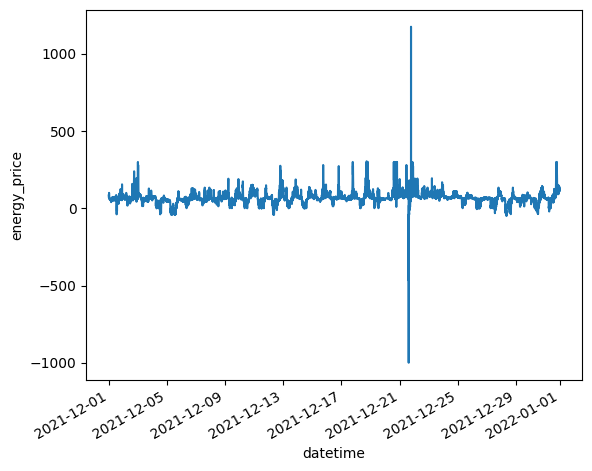

In [3]:
df = pd.read_parquet(Path.cwd().parent / "data")
df["SETTLEMENTDATE"] = pd.to_datetime(df["SETTLEMENTDATE"])
df = df.rename(columns={"SETTLEMENTDATE": "datetime", "RRP": "energy_price"})
df = df.query("INTERVENTION==0 and REGIONID=='NSW1'")
nsw_energy_price = df.set_index("datetime")["energy_price"].to_xarray()
nsw_energy_price.plot()

## Formulating the problem

### Mixed-integer bilinearly constrained problem

The formulation below is an intuitive formulation of the energy arbitrage problem that has bilinear terms (i.e. $q_tu_t$ or $p_tu_t$).

\begin{aligned}
\max_{t} \quad & \sum_{t}{\tau\lambda_t(p_t-q_t)}\\
\textrm{s.t.} \quad & 0 \leq p_t,q_t \leq \bar{p}\\
& u_t \in \{0,1\}    \\
& \underline{e} \leq e_t \leq \bar{e}    \\
& e_t-e_{t-1}- \left( q_t\eta_{charge}\tau\right)u_t+\frac{p_t\tau}{\eta_{discharge}}\left(1-u_t\right) = 0\\
& e_0 = 0.5\bar{e}\\
\end{aligned}

where:
- $\tau=\frac{1}{12} \textrm{hours}$
- $p_t$ corresponds to MW discharge at time $t$
- $q_t$ corresponds to MW charge at time $t$
- $u_t=1$ indicates charging, $u_t=0$ indicates discharging (*charge state*)
- $\bar{p}$ corresponds to the max power capacity in MW
- $\underline{e}$ and $\bar{e}$ corresponds to minimum and maximum state-of-charge limits, respectively
- $\lambda_t$ corresponds to the energy price in $/MWh at time $t$
- $\eta$ corresponds to efficiency (one term for charging and one term for discharging)

### Mixed-integer linear problem

Solving the mixed-integer bilinearly constrained program would require a mixed-integer quadratically-constrained program (MIQCP) solver. 

However, we can adapt the formulation to simplify the problem into a mixed-integer linear program (MILP) with one binary variable:

\begin{aligned}
\max_{t} \quad & \sum_{t}{\tau\lambda_t(p_t-q_t)}\\
\textrm{s.t.} \quad & u_t \in \{0,1\}    \\
& 0 \leq p_t \leq \bar{p}\\
& 0 \leq q_t \leq \bar{p} \\
& p_t - \bar{p}\left(1-u_t\right) \leq 0\\
& q_t - \bar{p}u_t \leq 0\\
& \underline{e} \leq e_t \leq \bar{e}    \\
& e_t-e_{t-1}- \left( q_t\eta_{charge}\tau\right)+\frac{p_t\tau}{\eta_{discharge}} = 0\\
& e_0 = 0.5\bar{e}\\
\end{aligned}

N.B. even though the state of operation constraints enforce charge/discharge limits via a binary variable, the solver will interpret the model as unbounded without the upper limit set on the continuous variables


In [4]:
def create_linopy_model(nsw_energy_price: xr.DataArray, solver: str):
    power_cap = 30.0  # MW
    energy_cap = 30.0  # MWh
    soc_lower_limit = 0.1 * energy_cap  # MWh
    soc_upper_limit = 0.9 * energy_cap  # MWh
    charge_eff = 0.9  # unitless
    discharge_eff = 0.9  # unitless
    tau = 5.0 / 60.0  # minutes per hour
    # initial conditions
    initial_soc_mwh = 0.5 * energy_cap  # MWh

    m = linopy.Model()

    # variables
    discharge_mw = m.add_variables(
        lower=0.0, upper=power_cap, coords=nsw_energy_price.coords, name="discharge_mw"
    )
    charge_mw = m.add_variables(
        lower=0.0, upper=power_cap, coords=nsw_energy_price.coords, name="charge_mw"
    )
    charge_state = m.add_variables(
        binary=True, coords=nsw_energy_price.coords, name="charge_state"
    )
    soc_mwh = m.add_variables(
        lower=soc_lower_limit,
        upper=soc_upper_limit,
        coords=nsw_energy_price.coords,
        name="soc_mwh",
    )

    # state of operation constraints
    discharge_operation = m.add_constraints(
        discharge_mw - power_cap * (1 - charge_state) <= 0,
        name="discharging-operation",
    )
    charge_operation = m.add_constraints(
        charge_mw - power_cap * charge_state <= 0, name="charging-operation"
    )
    # intertemporal energy balance constraints
    times = nsw_energy_price.coords["datetime"].values
    intertemp_soc_lhs = (
        soc_mwh.isel(datetime=slice(1, None))
        - soc_mwh.shift(datetime=1).isel(datetime=slice(1, None))
        - charge_mw.shift(datetime=1).isel(datetime=slice(1, None)) * charge_eff * tau
        + discharge_mw.shift(datetime=1).isel(datetime=slice(1, None))
        * tau
        / discharge_eff
    )
    intertemp_soc = m.add_constraints(
        intertemp_soc_lhs, "=", 0, "intemporal-energy-balance"
    )
    # initial SoC constraint
    initial_soc = m.add_constraints(
        soc_mwh.isel(datetime=0) == 0.5 * energy_cap, name="initial-soc"
    )
    # objective - add negative sign as linopy only permits minimisation
    obj = (-1 * nsw_energy_price * tau * (discharge_mw - charge_mw)).sum()
    m.add_objective(obj)
    m.solve(solver)
    return m

In [5]:
model = create_linopy_model(nsw_energy_price, "gurobi")

Writing binaries.: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 129.42it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-09


Read LP format model from file /tmp/linopy-problem-asv_tg9d.lp
Reading time = 0.08 seconds
obj: 26784 rows, 44640 columns, 71421 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 26784 rows, 44640 columns and 71421 nonzeros
Model fingerprint: 0xd9abc4de
Variable types: 35712 continuous, 8928 integer (8928 binary)
Coefficient statistics:
  Matrix range     [7e-02, 3e+01]
  Objective range  [1e-06, 1e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [2e+01, 2e+01]
Found heuristic solution: objective -153656.9184
Presolve removed 17861 rows and 18755 columns
Presolve time: 0.06s
Presolved: 8923 rows, 25885 columns, 35698 nonzeros
Variable types: 25885 continuous, 0 integer (0 binary)

Root relaxation: objective -4.146549e+05, 890 iterations, 0.16 seconds (0.72 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  

In [6]:
soln = model.solution.to_dataframe()

In [7]:
soln["charge_state"]

datetime
2021-12-01 00:05:00    1.0
2021-12-01 00:10:00    1.0
2021-12-01 00:15:00    1.0
2021-12-01 00:20:00    1.0
2021-12-01 00:25:00    1.0
                      ... 
2021-12-31 23:40:00    1.0
2021-12-31 23:45:00    1.0
2021-12-31 23:50:00    1.0
2021-12-31 23:55:00    1.0
2022-01-01 00:00:00    1.0
Name: charge_state, Length: 8928, dtype: float64

In [8]:
soln["discharge_mw"]

datetime
2021-12-01 00:05:00    30.000000
2021-12-01 00:10:00     9.599430
2021-12-01 00:15:00    30.000000
2021-12-01 00:20:00     0.000000
2021-12-01 00:25:00     0.000000
                         ...    
2021-12-31 23:40:00    30.000000
2021-12-31 23:45:00    30.000000
2021-12-31 23:50:00    30.000000
2021-12-31 23:55:00    18.599786
2022-01-01 00:00:00    30.000000
Name: discharge_mw, Length: 8928, dtype: float64

In [9]:
soln.loc[(soln["charge_mw"] > 0) & (soln["discharge_mw"] > 0)]

,discharge_mw,charge_mw,charge_state,soc_mwh
datetime,,,,
2021-12-02 15:10:00,30.0,14.074400,1.0,5.250000
2021-12-02 18:30:00,30.0,2.087818,1.0,26.843414
2021-12-02 21:50:00,30.0,19.198860,1.0,3.000000
2021-12-03 07:00:00,30.0,30.000000,1.0,5.250000
2021-12-03 08:40:00,30.0,30.000000,1.0,12.666630
...,...,...,...,...
2021-12-28 21:10:00,30.0,30.000000,1.0,5.638950
2021-12-29 08:00:00,30.0,20.000000,1.0,25.500000
2021-12-30 07:20:00,30.0,30.000000,1.0,9.727652
